In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Pythonで最小二乗法 

## numpyで行う場合 

### データの作成 

In [2]:
x = np.arange(0,1,0.01)

In [3]:
a = 2.0
b = 3.0

def func(x):
    return a*x+b

In [4]:
y = func(x) + 0.1*np.random.randn(len(x))

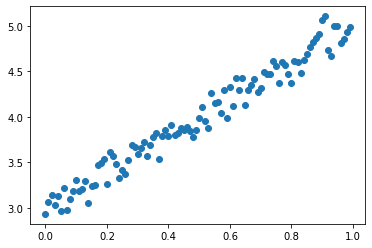

In [5]:
fig, ax = plt.subplots()
ax.scatter(x,y)

### 最小二乗法 

In [6]:
# 計画行列
X = np.stack([x,np.ones(len(x))],axis=1)

# 最小二乗解
inv_XtX = np.linalg.inv(np.dot(X.T,X))
Xty = np.dot(X.T,y)
beta_hat = np.dot(inv_XtX, Xty)
beta_hat

array([2.01218443, 2.99297416])

In [7]:
y_hat = np.dot(X, beta_hat)

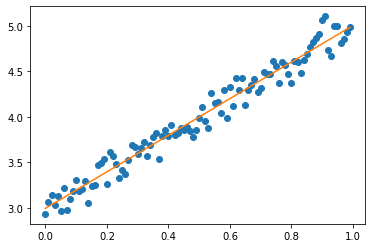

In [8]:
fig, ax = plt.subplots()
ax.scatter(x,y)
ax.plot(x,y_hat,color="C1")

## Pytorchで行う場合 

pytorchではバッチごとに行列の積`torch.bmm`，逆行列`torch.inverse`，転置`torch.transpose`が計算できるので，複数データを並行して最小二乗法などを用いるのが簡単

### データの作成 

In [9]:
x_1 = torch.from_numpy(np.arange(0,1,0.01))
x_2 = torch.from_numpy(np.arange(2,3,0.01))

b_x = torch.stack([x_1,x_2],dim=0)
b_x

tensor([[0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
         0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
         0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
         0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
         0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
         0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
         0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
         0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
         0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
         0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
         0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
         0.9900],
        [2.0000, 2.0100, 2.0200, 2.0300, 2.0400, 2.0500, 2.0600, 2.0700, 2.0800,
         2

In [10]:
a_1 = 2.0
b_1 = 3.0

a_2 = 4.0
b_2 = 5.0

def func1(x):
    return a_1*x+b_1

def func2(x):
    return a_2*x+b_2

In [11]:
y_1 = func1(x_1) + 0.1*torch.randn(len(x_1))
y_2 = func2(x_2) + 0.1*torch.randn(len(x_2))

b_y = torch.stack([y_1,y_2],dim=0)

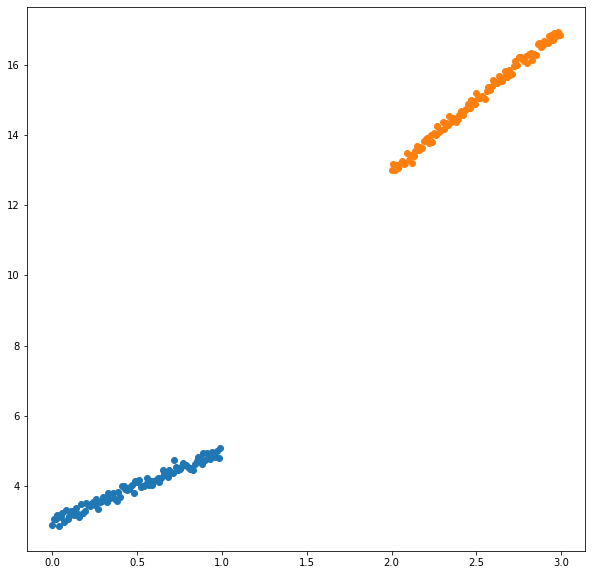

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(x_1.numpy(), y_1.numpy(), color="C0")
ax.scatter(x_2.numpy(), y_2.numpy(), color="C1")

### 最小二乗法 

In [13]:
# 計画行列
ones = torch.ones_like(b_x)
b_X = torch.stack([b_x, ones],dim=2)

# 最小二乗解
b_XtX = torch.bmm(b_X.transpose(1,2),b_X)
b_inv_XtX = torch.inverse(b_XtX)
b_Xty = torch.bmm(b_X.transpose(1,2),b_y[:,:,None])

b_beta_hat = torch.bmm(b_inv_XtX, b_Xty)  # (batch,2,1) であることに注意
b_beta_hat

tensor([[[2.0049],
         [3.0033]],

        [[4.0412],
         [4.8982]]], dtype=torch.float64)

In [14]:
b_y_hat = torch.bmm(b_X, b_beta_hat)

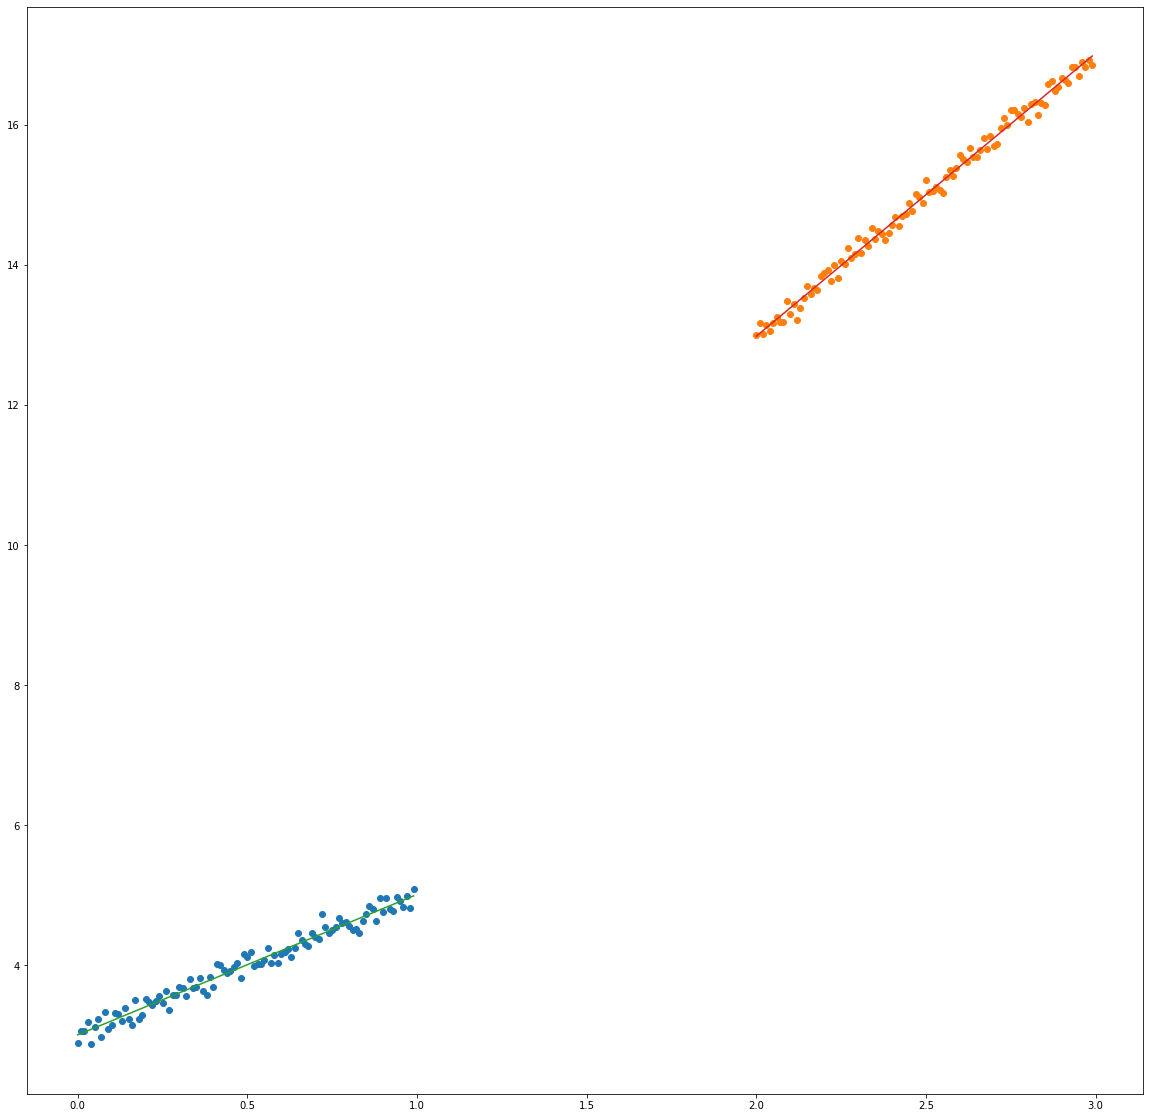

In [15]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(x_1.numpy(), y_1.numpy(), color="C0")
ax.scatter(x_2.numpy(), y_2.numpy(), color="C1")

ax.plot(x_1.numpy(), b_y_hat[0,:,:].squeeze(dim=1).numpy(),color="C2")
ax.plot(x_2.numpy(), b_y_hat[1,:,:].squeeze(dim=1).numpy(),color="C3")

## ransacについて

以上のアルゴリズムを用いて，簡易的な直線検出のransacを試す．手順としては
- すべての$n$個の点から，$s$点×$m$点(重複あり・なし)をサンプリングして$m$個それぞれの最小二乗解(直線)を求める．
- 各直線について，すべての点との距離を計算し，閾値以内に収まる点の数を求める．
- 最も閾値以内に収まる点の多い直線を結果とする．

### データの作成

直線のデータにノイズが加わったようなデータとしている．

In [16]:
a_1 = 2.0
b_1 = 3.0

a_2 = 2.0
b_2 = 4.0

def func1(x):
    return a_1*x+b_1

def func2(x):
    return a_2*x+b_2

In [17]:
x_1 = np.arange(0,1,0.01)
x_2 = np.arange(0.9,1,0.005)
all_x = np.concatenate([x_1,x_2],axis=0)

y_1 = func1(x_1) + 0.1*np.random.randn(len(x_1))
y_2 = func2(x_2) + 0.2*np.random.randn(len(x_2))
all_y = np.concatenate([y_1,y_2],axis=0)

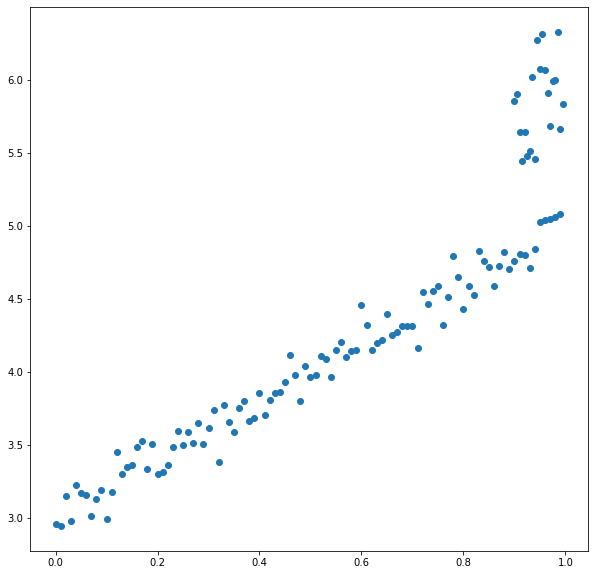

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(all_x, all_y, color="C0")

In [19]:
print("all_x length:",len(all_x))

all_x length: 120


### サンプリングの度合い

以下のような　直線の本数×一本の推定に利用する点数　の分だけデータをサンプリングする必要がある．

In [43]:
line_number = 1000
point_number = 5

distance_th = 0.1

以下では，
1. 一本の推定に利用する点数，それの直線の本数どちらにも重複があり得るサンプリング  
    複数の直線が同じになる可能性があり，直線が求められない可能性もある
2. 一本の推定に利用する点数のみ重複なし，それの直線の本数は重複があり得るサンプリング  
    複数の直線が同じになる可能性があるが，直線は求められる
3. どちらも重複がない  
    求める直線は全て異なり，直線も必ず求められる  
の3つのサンプリングを考える．

####  一本の推定に利用する点数，直線の本数分どちらにも重複があり得る

普通にrandintすればよい

In [21]:
random_index = np.random.randint(0,len(all_x),size=(line_number, point_number))
#random_index

#### 一本の推定に利用する点にのみ重複なし，それの直線の本数は重複があり得るサンプリング

重複の無いサンプリングには，インデックスをランダムに並べ替えて，そこから取り出せばよい．`np.random.permutation`は既存のndarrayをランダムに並び替えるか，ndarrayの長さを与えることでランダムに並び替えたインデックスを返す
これはデータ数がpoint_numberより大きな値をもてば利用でき，その条件は通常満たされる．

In [22]:
random_index = np.array([np.random.permutation(len(all_x))[:point_number] for i in range(line_number)])
#random_index

####  どちらにも重複がない

こちらの方がより簡単に実装できるが，linenumber×point_numberの数がデータ数より大きい必要がある

In [23]:
random_index_flatten = np.random.permutation(len(all_x))[:line_number*point_number]
random_index = random_index_flatten.reshape(line_number, point_number)
#random_index

今回は，より有用な2番を用いる．

In [46]:
random_index = np.array([np.random.permutation(len(all_x))[:point_number] for i in range(line_number)])

### numpyで行う場合 

for文で回しながら，最小二乗法を計算する

In [47]:
distance_vote_list = []
solution_list = []

solution_points_list = []  # おまけ

for points_index in random_index:
    # 利用するデータ
    x = all_x[points_index]
    y = all_y[points_index]
    
    # 計画行列
    X = np.stack([x,np.ones(len(x))],axis=1)

    # 最小二乗解
    inv_XtX = np.linalg.inv(np.dot(X.T,X))
    Xty = np.dot(X.T,y)
    beta_hat = np.dot(inv_XtX, Xty)
    a = beta_hat[0]
    b = - 1
    c = beta_hat[1]
    d_num = a * all_x + b * all_y + c  # (all_point_number(n))
    d_den = np.sqrt(a**2+b**2)  # 1
    d = np.abs(d_num) / d_den  # (all_point_number(n))
    
    vote_number = (d < distance_th).sum()
    
    distance_vote_list.append(vote_number)
    solution_list.append(beta_hat)
    
    solution_points_list.append(np.stack([x,y],axis=1))
    
solution_array = np.stack(solution_list, axis=0)
distance_vote_array = np.array(distance_vote_list)
ransac_solution_index = np.argmax(distance_vote_array,axis=0)
print("ransac solution index:",ransac_solution_index)

ransac_solution = solution_array[ransac_solution_index]
print("ransac solution:",ransac_solution)

ransac_solution_points = solution_points_list[ransac_solution_index]

ransac solution index: 118
ransac solution: [2.0568342  3.00660009]


In [26]:
print(distance_vote_array)

[96 90 87 66 65 75 19 94 52 52 56 68 92 95 60 61 81 66 64 67]


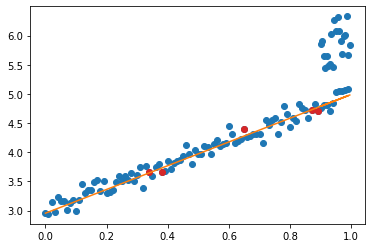

In [28]:
all_X = np.stack([all_x,np.ones(len(all_x))],axis=1)
ransac_y_hat = np.dot(all_X, ransac_solution)
fig,ax = plt.subplots()
ax.plot(all_x, ransac_y_hat, color="C1")
ax.scatter(all_x, all_y, color="C0")
ax.scatter(ransac_solution_points[:,0],ransac_solution_points[:,1],color="C3")

### pytorchで行う場合

In [48]:
all_x_tensor = torch.from_numpy(all_x)  # (all_point_number(n))
all_y_tensor = torch.from_numpy(all_y)  # (all_point_number(n))

b_x = torch.from_numpy(all_x[random_index])  # (line_number(m), point_number(s))
b_y = torch.from_numpy(all_y[random_index])  # (line_number(m), point_number(s))

# 計画行列
ones = torch.ones_like(b_x)
b_X = torch.stack([b_x, ones],dim=2)

# 最小二乗解
b_XtX = torch.bmm(b_X.transpose(1,2),b_X)
b_inv_XtX = torch.inverse(b_XtX)
b_Xty = torch.bmm(b_X.transpose(1,2),b_y[:,:,None])

b_beta_hat = torch.bmm(b_inv_XtX, b_Xty)  # (batch,2,1) であることに注意
b_beta_hat_squeezed = b_beta_hat.squeeze(2)  # (batch,2)

# 距離の計算
a = b_beta_hat_squeezed[:,0]  # (line_number(m))
c = b_beta_hat_squeezed[:,1]  # (line_number(m))
d_num = a[:,None] * all_x_tensor[None,:]  - all_y_tensor[None,:] + c[:,None]  # (line_number(m), all_point_number(n))
d_den = torch.sqrt(a**2+(-1)**2)  # (line_number(m))
d = torch.abs(d_num) / d_den[:,None]

b_vote_number = (d < distance_th).sum(dim=1)  # (line_number(m))
ransac_solution_index = np.argmax(b_vote_number.numpy(),axis=0)  # 正確な比較のためにnumpyで計算
print("ransac solution index:", ransac_solution_index)

ransac_solution = b_beta_hat_squeezed[ransac_solution_index].numpy()
print("ransac solution:", ransac_solution)

solution_points = torch.stack([b_x[ransac_solution_index,:],b_y[ransac_solution_index,:]],dim=1)

ransac solution index: 118
ransac solution: [2.0568342  3.00660009]


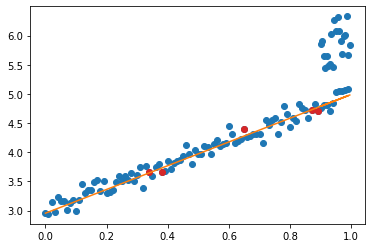

In [30]:
all_X = np.stack([all_x,np.ones(len(all_x))],axis=1)
ransac_y_hat = np.dot(all_X, ransac_solution)
fig,ax = plt.subplots()
ax.plot(all_x, ransac_y_hat, color="C1")
ax.scatter(all_x, all_y, color="C0")
ax.scatter(solution_points[:,0].numpy(),solution_points[:,1].numpy(),color="C3")